# 04 – Entity-Level R via Balance Method

This notebook demonstrates how to estimate an **entity-level cost ratio**:

> Rₑ = cuₑ / co

using the `estimate_entity_R_from_balance` helper, and then use those
entity-specific `cu` / `co` values when computing CWSL.

We will:

1. Build a small panel with multiple entities and different forecast biases.
2. Estimate Rₑ for each entity using the **balance method**.
3. Merge `cu` / `co` back to the panel.
4. Compare CWSL using a **global** cost ratio vs **entity-level** ratios.

In [1]:
import numpy as np
import pandas as pd

from cwsl import (
    cwsl,
    compute_cwsl_df,
    estimate_entity_R_from_balance,
)

In [2]:
rows = []

# Entity A: mostly over-forecast (tends to have overbuild)
for t, y in enumerate([10, 12, 15, 20, 18, 16], start=1):
    rows.append(
        {
            "entity": "A_over_lean",
            "t": t,
            "actual": y,
            "forecast": y + (2 if t % 2 == 0 else 1),  # always a bit high
        }
    )

# Entity B: roughly balanced around the truth
for t, y in enumerate([10, 12, 15, 20, 18, 16], start=1):
    bias = 1 if t % 2 == 0 else -1
    rows.append(
        {
            "entity": "B_balanced",
            "t": t,
            "actual": y,
            "forecast": y + bias,  # sometimes low, sometimes high
        }
    )

# Entity C: mostly under-forecast (tends to have shortfall)
for t, y in enumerate([10, 12, 15, 20, 18, 16], start=1):
    rows.append(
        {
            "entity": "C_under_lean",
            "t": t,
            "actual": y,
            "forecast": y - (2 if t % 2 == 0 else 1),  # always a bit low
        }
    )

df = pd.DataFrame(rows)
df.head(10)

,entity,t,actual,forecast
0,A_over_lean,1,10,11
1,A_over_lean,2,12,14
2,A_over_lean,3,15,16
3,A_over_lean,4,20,22
4,A_over_lean,5,18,19
5,A_over_lean,6,16,18
6,B_balanced,1,10,9
7,B_balanced,2,12,13
8,B_balanced,3,15,14
9,B_balanced,4,20,21


In [3]:
ratios = (0.5, 1.0, 2.0, 3.0)
co = 1.0  # shared overbuild cost

entity_costs = estimate_entity_R_from_balance(
    df=df,
    entity_col="entity",
    y_true_col="actual",
    y_pred_col="forecast",
    ratios=ratios,
    co=co,
    sample_weight_col=None,
)

entity_costs

,entity,R,cu,co,under_cost,over_cost,diff
0,A_over_lean,0.5,0.5,1.0,0.0,9.0,9.0
1,B_balanced,1.0,1.0,1.0,3.0,3.0,0.0
2,C_under_lean,0.5,0.5,1.0,4.5,0.0,4.5


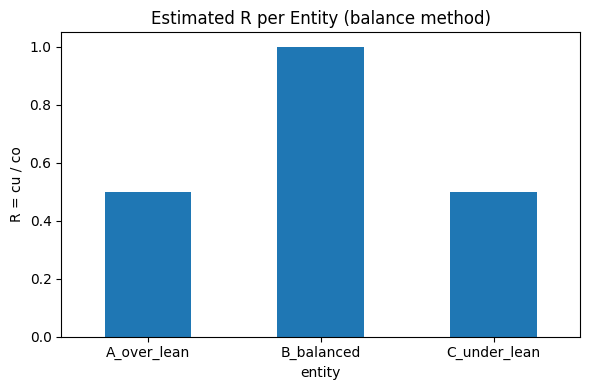

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
entity_costs.set_index("entity")["R"].plot(kind="bar")

plt.title("Estimated R per Entity (balance method)")
plt.ylabel("R = cu / co")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
# Global cost ratio: cu = 2.0, co = 1.0
global_cu = 2.0
global_co = 1.0

cwsl_global = compute_cwsl_df(
    df=df,
    y_true_col="actual",
    y_pred_col="forecast",
    cu=global_cu,
    co=global_co,
    sample_weight_col=None,
)

cwsl_global

0.13186813186813187

In [6]:
# Merge entity-level cu/co back into the panel
df_with_costs = df.merge(entity_costs[["entity", "cu", "co"]], on="entity", how="left")

df_with_costs.head()

,entity,t,actual,forecast,cu,co
0,A_over_lean,1,10,11,0.5,1.0
1,A_over_lean,2,12,14,0.5,1.0
2,A_over_lean,3,15,16,0.5,1.0
3,A_over_lean,4,20,22,0.5,1.0
4,A_over_lean,5,18,19,0.5,1.0


In [7]:
cwsl_entity_level = compute_cwsl_df(
    df=df_with_costs,
    y_true_col="actual",
    y_pred_col="forecast",
    cu="cu",  # column name with per-row cu
    co="co",  # column name with per-row co
    sample_weight_col=None,
)

cwsl_entity_level

0.07142857142857142

In [8]:
comparison = pd.DataFrame(
    {
        "CWSL_global_R2": [cwsl_global],
        "CWSL_entity_level": [cwsl_entity_level],
    }
)

comparison

,CWSL_global_R2,CWSL_entity_level
0,0.131868,0.071429


In [9]:
entities = sorted(df["entity"].unique())
rows = []

for ent in entities:
    g = df[df["entity"] == ent]

    # Global costs
    cwsl_global_ent = compute_cwsl_df(
        df=g,
        y_true_col="actual",
        y_pred_col="forecast",
        cu=global_cu,
        co=global_co,
        sample_weight_col=None,
    )

    # Entity-specific costs
    g_cost = df_with_costs[df_with_costs["entity"] == ent]
    cwsl_entity_ent = compute_cwsl_df(
        df=g_cost,
        y_true_col="actual",
        y_pred_col="forecast",
        cu="cu",
        co="co",
        sample_weight_col=None,
    )

    rows.append(
        {
            "entity": ent,
            "CWSL_global_R2": cwsl_global_ent,
            "CWSL_entity_level": cwsl_entity_ent,
            "R_entity": float(entity_costs.set_index("entity").loc[ent, "R"]),
        }
    )

per_entity_comparison = pd.DataFrame(rows)
per_entity_comparison

,entity,CWSL_global_R2,CWSL_entity_level,R_entity
0,A_over_lean,0.098901,0.098901,0.5
1,B_balanced,0.098901,0.065934,1.0
2,C_under_lean,0.197802,0.049451,0.5


## Conclusion

In this example we:

1. Built a small multi-entity panel with different bias patterns:
   - One entity that tends to **over-forecast** (more overbuild).
   - One that is roughly **balanced**.
   - One that tends to **under-forecast** (more shortfall).

2. Used `estimate_entity_R_from_balance` to derive an **Rₑ = cuₑ / co** for
   each entity, by finding the R in a candidate grid where the *observed*
   underbuild and overbuild costs are closest in magnitude.

3. Merged the resulting `cu` / `co` values back into the panel and computed:
   - CWSL under a **single global cost ratio**, and
   - CWSL under **entity-specific** cost ratios.

This gives you a practical workflow for:

- Starting with a global R (e.g., R = 2.0), and
- Optionally upgrading to **entity-level Rₑ** for high-impact entities, while
  still using the same CWSL metric and the same APIs.

In production, this table:

- `entity`, `R`, `cu`, `co`, `under_cost`, `over_cost`, `diff`

can be stored as a dimension-style reference and used to drive:
- evaluation (panel CWSL),
- dashboards,
- and eventually, **training with entity-specific costs** in future phases.